In [83]:
import docx
from glob import glob
import re
import os
import os.path
from string import punctuation
import pickle
from modAL.models import ActiveLearner

from wordcloud import WordCloud
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import nltk
import lightgbm as lgb
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold
from nltk.corpus import stopwords
from ftfy import fix_text
from sklearn.metrics import f1_score, classification_report, accuracy_score, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper, DeltaYStopper
from catboost import CatBoostClassifier, Pool
import catboost
%matplotlib inline

In [5]:
def check_highlighted_text(paragraph):
    for run in paragraph.runs:
        if run.font.highlight_color:
            return True
    return False

def get_text(filename):
    doc = docx.Document(filename)
    full_text, corrupt_text = [], []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
        if check_highlighted_text(paragraph):
            corrupt_text.append(paragraph.text)
    return "\n".join(full_text), "\n".join(corrupt_text)

def get_paragraph_with_labels(filename):
    doc = docx.Document(filename)
    paragraphs_with_labels = []
    highlight_text_flg = False
    for paragraph in doc.paragraphs:
        if paragraph.text:
            if check_highlighted_text(paragraph):
                paragraphs_with_labels.append((paragraph.text, 1, filename))
                highlight_text_flg = True
            else:
                paragraphs_with_labels.append((paragraph.text, 0, filename))
    return paragraphs_with_labels, highlight_text_flg

def get_label(filename):
    label = filename.split('/')[6]
    return label

def get_factor_description(filename):
    doc = docx.Document(filename)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
        if check_highlighted_text(paragraph):
            corrupt_text.append(paragraph.text)
    return "\n".join(full_text), "\n".join(corrupt_text)

In [ ]:
texts = dict()

for file_path in tqdm(glob("/home/hackathon/dataset/dataset_razmetka/**/*.docx", recursive=True)):
    if "~$" in file_path:
        continue
    label = file_path.strip('/').split('/')[5]
    
    if file_path not in texts:
        texts[file_path] = {'expertise_text': np.nan, 
                            'full_nc_text': np.nan, 
                            'corrupt_nc_text': np.nan,
                            'full_text': np.nan,
                            'corrupt_text': np.nan,
                            'label': label
                           }
        
    if 'Expertise_Text' in file_path:
        try:
            full_expertise_text, _ = get_text(file_path)
            texts[file_path]['expertise_text'] = full_expertise_text
        except:
            continue
    if '/NC_Edition_Text' in file_path:
        try:
            full_nc_text, corrupt_nc_text = get_text(file_path)
            texts[file_path]['full_nc_text'] = full_nc_text
            texts[file_path]['corrupt_nc_text'] = corrupt_nc_text
        except:
            continue
    if '/Edition_Text' in file_path:
        try:
            full_text, corrupt_text = get_text(file_path)
            texts[file_path]['full_text'] = full_text
            texts[file_path]['corrupt_text'] = corrupt_text
        except:
            continue

In [7]:
raw_texts_df = pd.DataFrame.from_dict(texts).T
raw_texts_df.reset_index(inplace=True)
raw_texts_df.rename(columns={'index': 'path'}, inplace=True)
raw_texts_df.to_csv('raw_texts.csv', index=False)

NameError: name 'texts' is not defined

In [8]:
raw_texts_df = pd.read_csv('raw_texts.csv')

In [9]:
def return_data_without_nulls(data, col):
    grouped_data = data.groupby('path')[col].apply(set).reset_index()
    grouped_data = grouped_data[grouped_data[col] != {np.nan}]
    grouped_data[col] = grouped_data[col].apply(lambda x: list(x)[0])
    return grouped_data

full_nc_text = return_data_without_nulls(raw_texts_df, 'full_nc_text')
expertise_text = return_data_without_nulls(raw_texts_df, 'expertise_text')
corrupt_nc_text = return_data_without_nulls(raw_texts_df, 'corrupt_nc_text')
full_text = return_data_without_nulls(raw_texts_df, 'full_text')
corrupt_text = return_data_without_nulls(raw_texts_df, 'corrupt_text')

In [10]:
full_nc_text.shape, expertise_text.shape, corrupt_nc_text.shape, full_text.shape, corrupt_text.shape

((5452, 2), (5377, 2), (4158, 2), (5441, 2), (4241, 2))

In [11]:
nc_texts = pd.merge(full_nc_text, corrupt_nc_text)
source_texts = pd.merge(full_text, corrupt_text)

In [30]:
texts_df = pd.merge(source_texts, raw_texts_df, on='path', suffixes=('', '_y'))
texts_df = texts_df.iloc[:, [0, 1, 2, -1]]

In [31]:
add_freq_labels = [value for value in dict(texts_df['label'].value_counts()).values()]

In [32]:
dict(np.c_[list(dict(texts_df['label'].value_counts()).keys()), add_freq_labels])

{'4_1': '884',
 '3_3': '691',
 '3_7': '608',
 '3_1': '574',
 '3_9': '445',
 '3_5': '368',
 '4_2': '233',
 '4_3': '181',
 '3_2': '166',
 '3_6': '53',
 '3_4': '35',
 '3_8': '3'}

In [33]:
map_to_replace = {old_label: new_label for new_label, old_label in enumerate(texts_df['label'].unique())}
texts_df['label'] = texts_df['label'].map(map_to_replace)
texts_df.dropna(inplace=True)

In [15]:
map_to_replace

{'3_1': 0,
 '3_2': 1,
 '3_5': 2,
 '3_9': 3,
 '4_1': 4,
 '4_3': 5,
 '3_3': 6,
 '3_7': 7,
 '4_2': 8,
 '3_4': 9,
 '3_6': 10,
 '3_8': 11}

In [ ]:
def vectorize_text(text):
    file_vectorizer = open('new_vectorizer.pkl', 'rb')
    vectorizer = pickle.load(file_vectorizer)
    vectorized_text = vectorizer.transform(text)
    return vectorized_text

def predict_factor(vectorized_text):
    file_logreg = open('logreg.pkl', 'rb')
    lr = pickle.load(file_vectorizer)
    predicted_factor = lr.predict(vectorized_text)
    return predicted_factor

vectorized_text = vectorize_text(corrupt_text)
factor = predict_factor(vectorized_text)

In [ ]:
# texts_df['count_puncts'] = texts_df['corrupt_text'].apply(lambda x: len(re.findall(r'[.,:?;!)(]*', x)))
# texts_df = texts_df[texts_df['count_puncts'] != texts_df['count_puncts'].max()]

# texts_df['corrupt_text'] = texts_df['corrupt_text'].apply(lambda x: re.sub(r'\s', ' ', x.strip()))
# texts_df['first_word'] = texts_df['corrupt_text'].apply(lambda x: x.split(' ')[0].strip().lower())
# texts_df['last_word'] = texts_df['corrupt_text'].apply(lambda x: x.split(' ')[-1].strip().lower())
# texts_df['count_decimal'] = texts_df['corrupt_text'].apply(lambda x: len(re.findall(r'[0-9]+', x)))
# texts_df['count_uppercased_chars'] = texts_df['corrupt_text'].apply(lambda x: len(re.findall(r'[A-ZA-Я]+', x)))
# texts_df['len_line'] = texts_df['corrupt_text'].apply(lambda x: len(x))
# texts_df['count_stopwords'] = texts_df['corrupt_text'].apply(lambda x: len([token for token in x.split(' ') if token in stopwords.words('russian')]))

In [54]:
texts_df['label'].value_counts(normalize=True) * 100

4     20.844141
6     16.293327
7     14.336241
0     13.534544
3     10.492808
2      8.677199
8      5.493987
5      4.267861
1      3.914171
10     1.249705
9      0.825277
11     0.070738
Name: label, dtype: float64

In [20]:
#texts_df['len_line'] = texts_df['corrupt_text'].apply(lambda x: len(x))
#texts_df = texts_df[(texts_df['len_line'].quantile(0.10) < texts_df['len_line']) & (texts_df['len_line'] < texts_df['len_line'].quantile(0.90))]

In [21]:
texts_df['label'].value_counts()

4     705
6     536
0     487
7     437
3     396
2     305
8     163
5     162
1     138
9      32
10     27
11      3
Name: label, dtype: int64

In [34]:
corrupt_texts = ' '.join([str(row) for row in texts_df['corrupt_text'].values.tolist()])

vectorizer = TfidfVectorizer(corrupt_texts, ngram_range=(1, 2), stop_words=stopwords.words('russian'), min_df=0.005)
x_train, x_test, y_train, y_test = train_test_split(texts_df['corrupt_text'].values, texts_df['label'].values, test_size=0.1, random_state=42, stratify=texts_df['label'].values)
dop_text = x_train[y_train == 11][0]
x_test = np.append(x_test, x_train[y_train == 11][0])
y_test = np.append(y_test, 11)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [45]:
lr = LogisticRegression(solver='saga', C=1000, penalty='none')

learner = ActiveLearner(
                        estimator=lr,
    X_training=x_train, y_training=y_train
)

/home/hackathon/code/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/hackathon/code/venv/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [46]:
#lr.fit(x_train, y_train)
y_pred = learner.predict(x_test)
accuracy_score(y_test, y_pred)

0.4812206572769953

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.41      0.39        58
           1       1.00      0.29      0.45        17
           2       0.60      0.57      0.58        37
           3       0.48      0.51      0.49        45
           4       0.62      0.88      0.73        89
           5       0.50      0.22      0.31        18
           6       0.50      0.48      0.49        69
           7       0.41      0.43      0.42        61
           8       0.67      0.17      0.28        23
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         5
          11       0.00      0.00      0.00         1

    accuracy                           0.53       426
   macro avg       0.60      0.44      0.47       426
weighted avg       0.54      0.53      0.51       426



/home/hackathon/code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hackathon/code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hackathon/code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [139]:
pickle.dump(vectorizer, open('../models/vectorizer.pkl', 'wb'))
pickle.dump(lr, open('../models/logreg.pkl', 'wb'))

In [47]:
def return_feat_imp(model, label, vectorizer):
    feat_imp = pd.DataFrame(np.c_[list(vectorizer.vocabulary_), model.coef_[label]], columns=['word', 'coef'])
    feat_imp['coef'] = feat_imp['coef'].astype('float64')
    return feat_imp.sort_values(by='coef', ascending=False)

def create_features_from_feat_imp(data, feature_importances):
    best_words = feature_importances['word'].head(10).values
    for word in best_words:
        col_name = 'gram_' + word.replace(' ', '_') + '_flg'
        data[col_name] = data['line'].apply(lambda x: 1 if word.lower() in x else 0)
    return data

In [56]:
return_feat_imp(lr, 2, vectorizer).head(15)

,word,coef
3658,заверенные,12.742390
2335,тысяч,9.669672
3626,нарушением требований,9.181961
2705,летнего,8.446023
78,прилагаются,8.261875
975,физическим,7.718153
3151,инвалидности,7.608404
2933,иного документа,7.309854
1423,отказывает удовлетворении,7.290484
3819,10 дней,7.239311


In [3]:
glob("/home/hackathon/dataset/dataset_razmetka/**/*Edition_Text.docx", recursive=True)[0]

'/home/hackathon/dataset/dataset_razmetka/Волгоградская область/4_1/C3672823-62B8-4565-B451-C6F4AD43746C/Edition_4/Edition_Text.docx'

In [6]:
edition_texts = []
paths = glob("/home/hackathon/dataset/dataset_razmetka/**/Edition_Text.docx", recursive=True)

for file_path in tqdm(paths):
    try:
        marked_text, highlight_text_flg = get_paragraph_with_labels(file_path)
        if highlight_text_flg:
            edition_texts.extend(marked_text)
    except:
        pass

100%|███████████████████████████████████████████████████████████████████████████████| 5441/5441 [03:18<00:00, 27.47it/s]


In [7]:
ed_texts_df = pd.DataFrame(edition_texts, columns=['line', 'label', 'file_path'])
ed_texts_df['factor'] = ed_texts_df['file_path'].apply(lambda file_path: file_path.strip('/').split('/')[5])
ed_texts_df.to_csv('ed_texts_df.csv', index=False)

In [35]:
ed_texts_df = pd.read_csv('ed_texts_df.csv')
ed_texts_df_0 = ed_texts_df[ed_texts_df['label'] == 0]
ed_texts_df_0 = ed_texts_df_0.sample(int(ed_texts_df_0.shape[0] * 0.4))
ed_texts_df_1 = ed_texts_df[ed_texts_df['label'] == 1]
ed_texts_df = pd.concat([ed_texts_df_0, ed_texts_df_1])

In [13]:
ed_texts_df.shape

(715136, 4)

In [ ]:
# #prepare data for gpt

# corrupt_ed_texts_df = ed_texts_df[ed_texts_df['label'] == 1]
# joined_corrupt_ed_texts_df = corrupt_ed_texts_df.groupby('file_path', as_index=False)['line'].apply(lambda x: '<br>'.join(x))
# joined_corrupt_ed_texts_df.drop_duplicates(['line'], inplace=True)
# joined_corrupt_ed_texts_df = pd.merge(joined_corrupt_ed_texts_df, corrupt_ed_texts_df, how='left', on='file_path')
# joined_corrupt_ed_texts_df = joined_corrupt_ed_texts_df.iloc[:, [0, 1, 3, 4]]
# joined_corrupt_ed_texts_df.drop_duplicates(['file_path', 'line_x'], inplace=True)
# joined_corrupt_ed_texts_df['prepared_line'] = '[' + joined_corrupt_ed_texts_df['factor'] + '] ' + joined_corrupt_ed_texts_df['line_x'].apply(lambda x: fix_text(x))
# joined_corrupt_ed_texts_df['prepared_line'] = joined_corrupt_ed_texts_df['prepared_line'].apply(lambda x: re.sub(r'\s', ' ', x))
# prepared_lines = joined_corrupt_ed_texts_df['prepared_line'].sample(joined_corrupt_ed_texts_df['file_path'].shape[0]).values

# with open('../dataset/gpt_corrupt_lines_1.txt', 'w') as f:
#     f.write('\n'.join(prepared_lines[:1600]))
    
# with open('../dataset/gpt_corrupt_lines_2.txt', 'w') as f:
#     f.write('\n'.join(prepared_lines[1600:3200]))

# with open('../dataset/gpt_corrupt_lines_3.txt', 'w') as f:
#     f.write('\n'.join(prepared_lines[3200:4800]))
    
# with open('../dataset/gpt_corrupt_lines_4.txt', 'w') as f:
#     f.write('\n'.join(prepared_lines[4800:6400]))

In [57]:
generated_data_folder = os.listdir('../dataset/generated_data')

In [58]:
generated_data = pd.DataFrame(columns=['text', 'label'])

for file_name in generated_data_folder:
    file_path = os.path.join('/home/hackathon/dataset/generated_data', file_name)
    new_generated_data = pd.read_csv(file_path)
    generated_data = generated_data.append(new_generated_data)
    
generated_data_1 = pd.read_csv('../dataset/generated_texts.csv')

generated_data = pd.concat([generated_data, generated_data_1])
generated_data.drop_duplicates(['text'], inplace=True)

In [70]:
generated_data.values[:2].tolist()[1]

['[3_1] 6.2. Работнику учреждения может быть оказана материальная помощь в случаях:\n1) вступления работника учреждения в брак;\n2) рождения у работника учреждения ребёнка либо усыновления им ребёнка;\n3) наличия у работника учреждения тяжёлого заболевания, требующего продолжительного и (или) дорогостоящего лечения;\n4) смерти супруга (супруги) и (или) близких родственников работника учреждения.',
 '3_1']

In [59]:
generated_data['label'].unique()

array(['3_1', '3_6', '3_9', '3_3', '4_3', '3_7', '3_2', '4_2', '3_8',
       '3_5', '4_1', '3_4'], dtype=object)

In [38]:
generated_data['new_text'] = generated_data['text'].apply(lambda x: x[6:])

In [39]:
generated_lines = []

for row in generated_data.values:
    text_lines = row[2].split('\n')
    lines_label = [(line, 1) for line in text_lines]
    generated_lines.extend(lines_label)

In [40]:
generated_lines = pd.DataFrame(generated_lines, columns=['line', 'label'])

In [65]:
def get_text(filename):
    doc = docx.Document(filename)
    full_text = []
    for paragraph in doc.paragraphs:
        if paragraph.text:
            full_text.append(paragraph.text)
    return full_text

def get_label(filename):
    label = filename.split('/')[6]
    return label

def preprocess_data(data):
    data['line'] = data['line'].apply(lambda x: re.sub(r'\s', ' ', str(x).strip()))
    data['len_line'] = data['line'].apply(lambda x: len(x))
    data['first_word'] = data['line'].apply(lambda x: x.split(' ')[0].strip().lower())
    data['last_word'] = data['line'].apply(lambda x: x.split(' ')[-1].strip().lower())
    data['count_decimal'] = data['line'].apply(lambda x: len(re.findall(r'[0-9]+', x)))
    data['count_uppercased_chars'] = data['line'].apply(lambda x: len(re.findall(r'[A-ZA-Я]+', x)))
    data['count_stopwords'] = data['line'].apply(lambda x: len([token for token in x.split(' ') if token in stopwords.words('russian')]))
    data['count_puncts'] = data['line'].apply(lambda x: len(re.findall(r'[.,:?;!)(*%#]\"\'', x)))
    return data

def return_feat_imp(model, label, vectorizer):
    feat_imp = pd.DataFrame(np.c_[list(vectorizer.vocabulary_), model.coef_[label]], columns=['word', 'coef'])
    feat_imp['coef'] = feat_imp['coef'].astype('float64')
    return feat_imp.sort_values(by='coef', ascending=False)

def create_features_from_feat_imp(data, feature_importances):
    best_words = feature_importances['word'].head(10).values
    for word in best_words:
        col_name = 'gram_' + word.replace(' ', '_') + '_flg'
        data[col_name] = data['line'].apply(lambda x: 1 if word.lower() in x else 0)
    return data

In [41]:
ed_texts_df = pd.concat([ed_texts_df[['line', 'label']], generated_lines])
ed_texts_df['line'] = ed_texts_df['line'].apply(lambda x: re.sub(r'\s', ' ', str(x).strip()))
ed_texts_df['len_line'] = ed_texts_df['line'].apply(lambda x: len(x))
#ed_texts_df = ed_texts_df[ed_texts_df['len_line'] > 100]
ed_texts_df.drop_duplicates(inplace=True)
ed_texts_df['first_word'] = ed_texts_df['line'].apply(lambda x: x.split(' ')[0].strip().lower())
ed_texts_df['last_word'] = ed_texts_df['line'].apply(lambda x: x.split(' ')[-1].strip().lower())
ed_texts_df['count_decimal'] = ed_texts_df['line'].apply(lambda x: len(re.findall(r'[0-9]+', x)))
ed_texts_df['count_uppercased_chars'] = ed_texts_df['line'].apply(lambda x: len(re.findall(r'[A-ZA-Я]+', x)))
ed_texts_df['count_stopwords'] = ed_texts_df['line'].apply(lambda x: len([token for token in x.split(' ') if token in stopwords.words('russian')]))
ed_texts_df['count_puncts'] = ed_texts_df['line'].apply(lambda x: len(re.findall(r'[.,:?;!)(]*', x)))

In [42]:
map_to_replace = {
                    '3_1': 0,
                    '3_2': 1,
                    '3_5': 2,
                    '3_9': 3,
                    '4_1': 4,
                    '4_3': 5,
                    '3_3': 6,
                    '3_7': 7,
                    '4_2': 8,
                    '3_4': 9,
                    '3_6': 10,
                    '3_8': 11
                }

for i in range(len(map_to_replace)):
    feat_imp = return_feat_imp(lr, i, vectorizer)
    ed_texts_df = create_features_from_feat_imp(ed_texts_df, feat_imp)

/home/hackathon/code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


In [43]:
ed_texts_df.to_csv('../dataset/ed_texts_df.csv', index=False)

In [71]:
ed_texts_df = pd.read_csv('../dataset/ed_texts_df.csv')

cols = list(ed_texts_df)
cols.pop(cols.index('label'))
ed_texts_df = ed_texts_df[(ed_texts_df['len_line'].quantile(0.10) < ed_texts_df['len_line']) & (ed_texts_df['len_line'] < ed_texts_df['len_line'].quantile(0.90))]

ed_texts_df_0 = ed_texts_df[ed_texts_df['label'] == 0]
train_ed_texts_df_0, holdout_ed_texts_df_0 = train_test_split(ed_texts_df_0, test_size=0.84, random_state=42, stratify=ed_texts_df_0['label'])
#print(train_ed_texts_df_0.shape, holdout_ed_texts_df_0.shape)
ed_texts_df_1 = ed_texts_df[ed_texts_df['label'] == 1]
ed_texts_df = pd.concat([ed_texts_df_1, train_ed_texts_df_0])
ed_texts_df.dropna(inplace=True)
print(ed_texts_df.shape)
print(ed_texts_df[ed_texts_df['label'] == 1].shape)
print(ed_texts_df[ed_texts_df['label'] == 0].shape)

(95733, 127)
(47243, 127)
(48490, 127)


In [72]:
x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(ed_texts_df[cols]), 
                                                    ed_texts_df['label'], 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=ed_texts_df['label'])

learner = ActiveLearner(
                        estimator=CatBoostClassifier(
                        cat_features=['first_word', 'last_word'],
                        text_features=['line'],
                        loss_function='Logloss',
                        eval_metric='AUC',
                        task_type='CPU',
                        text_processing = {
                            "tokenizers" : [{
                                "tokenizer_id" : "Space",
                                "separator_type" : "ByDelimiter",
                                "delimiter" : " "
                            }],

                            "dictionaries" : [{
                                "dictionary_id" : "BiGram",
                                "token_level_type": "Letter",
                                "max_dictionary_size" : "50000",
                                "occurrence_lower_bound" : "1",
                                "gram_order" : "2"
                            },
                            {
                                "dictionary_id" : "UniGram",
                                "token_level_type": "Letter",
                                "max_dictionary_size" : "50000",
                                "occurrence_lower_bound" : "3",
                                "gram_order" : "1"
                            }
                            ],

                            "feature_processing" : {
                                "default" : [
                                        {
                                        "dictionaries_names" : ["UniGram", "BiGram"],
                                        "feature_calcers" : ["BoW"],
                                        "tokenizers_names" : ["Space"]
                                    },
                                        {
                                    "dictionaries_names" : ["UniGram", "BiGram"],
                                    "feature_calcers" : ["NaiveBayes"],
                                    "tokenizers_names" : ["Space"]
                                },{
                                    "dictionaries_names" : ["UniGram", "BiGram"],
                                    "feature_calcers" : ["BM25"],
                                    "tokenizers_names" : ["Space"]
                                },
                                ],
                            }
                        }
                    ),
    X_training=x_train, y_training=y_train
)

Learning rate set to 0.069073
0:	total: 97.6ms	remaining: 1m 37s
1:	total: 122ms	remaining: 1m
2:	total: 151ms	remaining: 50s
3:	total: 174ms	remaining: 43.4s
4:	total: 197ms	remaining: 39.1s
5:	total: 221ms	remaining: 36.6s
6:	total: 249ms	remaining: 35.4s
7:	total: 272ms	remaining: 33.8s
8:	total: 295ms	remaining: 32.5s
9:	total: 319ms	remaining: 31.6s
10:	total: 344ms	remaining: 30.9s
11:	total: 367ms	remaining: 30.2s
12:	total: 391ms	remaining: 29.7s
13:	total: 414ms	remaining: 29.1s
14:	total: 437ms	remaining: 28.7s
15:	total: 463ms	remaining: 28.5s
16:	total: 486ms	remaining: 28.1s
17:	total: 509ms	remaining: 27.8s
18:	total: 534ms	remaining: 27.6s
19:	total: 559ms	remaining: 27.4s
20:	total: 581ms	remaining: 27.1s
21:	total: 605ms	remaining: 26.9s
22:	total: 631ms	remaining: 26.8s
23:	total: 653ms	remaining: 26.6s
24:	total: 677ms	remaining: 26.4s
25:	total: 702ms	remaining: 26.3s
26:	total: 725ms	remaining: 26.1s
27:	total: 750ms	remaining: 26s
28:	total: 771ms	remaining: 25.8s

240:	total: 5.56s	remaining: 17.5s
241:	total: 5.58s	remaining: 17.5s
242:	total: 5.61s	remaining: 17.5s
243:	total: 5.63s	remaining: 17.4s
244:	total: 5.65s	remaining: 17.4s
245:	total: 5.67s	remaining: 17.4s
246:	total: 5.7s	remaining: 17.4s
247:	total: 5.72s	remaining: 17.3s
248:	total: 5.74s	remaining: 17.3s
249:	total: 5.76s	remaining: 17.3s
250:	total: 5.79s	remaining: 17.3s
251:	total: 5.81s	remaining: 17.2s
252:	total: 5.83s	remaining: 17.2s
253:	total: 5.85s	remaining: 17.2s
254:	total: 5.87s	remaining: 17.2s
255:	total: 5.9s	remaining: 17.1s
256:	total: 5.92s	remaining: 17.1s
257:	total: 5.94s	remaining: 17.1s
258:	total: 5.96s	remaining: 17.1s
259:	total: 5.99s	remaining: 17s
260:	total: 6.01s	remaining: 17s
261:	total: 6.03s	remaining: 17s
262:	total: 6.05s	remaining: 17s
263:	total: 6.08s	remaining: 16.9s
264:	total: 6.1s	remaining: 16.9s
265:	total: 6.12s	remaining: 16.9s
266:	total: 6.14s	remaining: 16.9s
267:	total: 6.16s	remaining: 16.8s
268:	total: 6.18s	remaining: 16

480:	total: 11s	remaining: 11.8s
481:	total: 11s	remaining: 11.8s
482:	total: 11s	remaining: 11.8s
483:	total: 11s	remaining: 11.8s
484:	total: 11s	remaining: 11.7s
485:	total: 11.1s	remaining: 11.7s
486:	total: 11.1s	remaining: 11.7s
487:	total: 11.1s	remaining: 11.7s
488:	total: 11.1s	remaining: 11.6s
489:	total: 11.2s	remaining: 11.6s
490:	total: 11.2s	remaining: 11.6s
491:	total: 11.2s	remaining: 11.6s
492:	total: 11.2s	remaining: 11.5s
493:	total: 11.2s	remaining: 11.5s
494:	total: 11.3s	remaining: 11.5s
495:	total: 11.3s	remaining: 11.5s
496:	total: 11.3s	remaining: 11.5s
497:	total: 11.3s	remaining: 11.4s
498:	total: 11.4s	remaining: 11.4s
499:	total: 11.4s	remaining: 11.4s
500:	total: 11.4s	remaining: 11.4s
501:	total: 11.4s	remaining: 11.3s
502:	total: 11.5s	remaining: 11.3s
503:	total: 11.5s	remaining: 11.3s
504:	total: 11.5s	remaining: 11.3s
505:	total: 11.5s	remaining: 11.2s
506:	total: 11.5s	remaining: 11.2s
507:	total: 11.6s	remaining: 11.2s
508:	total: 11.6s	remaining: 1

720:	total: 16.3s	remaining: 6.33s
721:	total: 16.4s	remaining: 6.3s
722:	total: 16.4s	remaining: 6.28s
723:	total: 16.4s	remaining: 6.26s
724:	total: 16.4s	remaining: 6.24s
725:	total: 16.5s	remaining: 6.21s
726:	total: 16.5s	remaining: 6.19s
727:	total: 16.5s	remaining: 6.17s
728:	total: 16.5s	remaining: 6.14s
729:	total: 16.5s	remaining: 6.12s
730:	total: 16.6s	remaining: 6.1s
731:	total: 16.6s	remaining: 6.08s
732:	total: 16.6s	remaining: 6.05s
733:	total: 16.6s	remaining: 6.03s
734:	total: 16.7s	remaining: 6s
735:	total: 16.7s	remaining: 5.98s
736:	total: 16.7s	remaining: 5.96s
737:	total: 16.7s	remaining: 5.93s
738:	total: 16.7s	remaining: 5.91s
739:	total: 16.8s	remaining: 5.89s
740:	total: 16.8s	remaining: 5.87s
741:	total: 16.8s	remaining: 5.84s
742:	total: 16.8s	remaining: 5.82s
743:	total: 16.9s	remaining: 5.8s
744:	total: 16.9s	remaining: 5.78s
745:	total: 16.9s	remaining: 5.75s
746:	total: 16.9s	remaining: 5.73s
747:	total: 16.9s	remaining: 5.71s
748:	total: 17s	remaining:

961:	total: 21.8s	remaining: 859ms
962:	total: 21.8s	remaining: 837ms
963:	total: 21.8s	remaining: 814ms
964:	total: 21.8s	remaining: 792ms
965:	total: 21.8s	remaining: 769ms
966:	total: 21.9s	remaining: 746ms
967:	total: 21.9s	remaining: 724ms
968:	total: 21.9s	remaining: 701ms
969:	total: 21.9s	remaining: 678ms
970:	total: 22s	remaining: 656ms
971:	total: 22s	remaining: 633ms
972:	total: 22s	remaining: 611ms
973:	total: 22s	remaining: 588ms
974:	total: 22s	remaining: 565ms
975:	total: 22.1s	remaining: 543ms
976:	total: 22.1s	remaining: 520ms
977:	total: 22.1s	remaining: 497ms
978:	total: 22.1s	remaining: 475ms
979:	total: 22.2s	remaining: 452ms
980:	total: 22.2s	remaining: 430ms
981:	total: 22.2s	remaining: 407ms
982:	total: 22.2s	remaining: 384ms
983:	total: 22.2s	remaining: 362ms
984:	total: 22.3s	remaining: 339ms
985:	total: 22.3s	remaining: 317ms
986:	total: 22.3s	remaining: 294ms
987:	total: 22.3s	remaining: 271ms
988:	total: 22.4s	remaining: 249ms
989:	total: 22.4s	remaining: 2

In [76]:
y_pred = learner.predict_proba(x_test)

In [77]:
accuracies = []
f1_scores = []

for treshold in tresholds:
    y_probs = learner.predict_proba(x_test)
    y_preds = np.where(y_probs[:, 1] > treshold, 1, 0)
    accuracies.append((treshold, accuracy_score(y_preds, y_test)))
    f1_scores.append((treshold, f1_score(y_preds, y_test)))

In [78]:
accuracies

[(0.1, 0.5739502820137874),
 (0.2, 0.6494673072905787),
 (0.3, 0.7150616252350115),
 (0.4, 0.749321077919365),
 (0.5, 0.7702109880927512),
 (0.6, 0.7622728222268644),
 (0.7, 0.732504700229789),
 (0.8, 0.6685815750992271),
 (0.9, 0.5809484019218717)]

In [79]:
f1_scores

[(0.1, 0.696976450486591),
 (0.2, 0.7318632150846917),
 (0.3, 0.7633587786259541),
 (0.4, 0.7730281823340269),
 (0.5, 0.7710241465445462),
 (0.6, 0.736207695873899),
 (0.7, 0.664922150987832),
 (0.8, 0.5159420289855072),
 (0.9, 0.26895043731778423)]

In [80]:
y_probs = learner.predict_proba(x_test)
y_preds = np.where(y_probs[:, 1] > 0.4, 1, 0)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72      4849
           1       0.70      0.86      0.77      4725

    accuracy                           0.75      9574
   macro avg       0.76      0.75      0.75      9574
weighted avg       0.76      0.75      0.75      9574



In [81]:
y_probs = learner.predict_proba(x_test)
y_preds = np.where(y_probs[:, 1] > 0.4, 1, 0)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72      4849
           1       0.70      0.86      0.77      4725

    accuracy                           0.75      9574
   macro avg       0.76      0.75      0.75      9574
weighted avg       0.76      0.75      0.75      9574



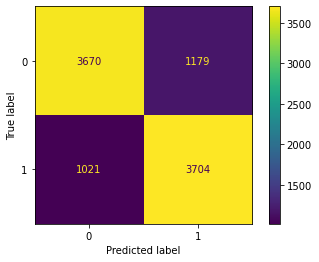

In [84]:
plot_confusion_matrix(learner.estimator, x_test, y_test)  
plt.show()

In [194]:
learner.estimator

In [195]:
CatBoostClassifier.save_model(learner.estimator, 'model')

In [72]:
print(classification_report(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [51]:
x_pool = holdout_ed_texts_df_0[cols]
query_idx, query_inst = learner.query(x_pool, 1000)


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [53]:
x_pool.iloc[query_idx]

,line,len_line,first_word,last_word,count_decimal,count_uppercased_chars,count_stopwords,count_puncts,gram_подтверждающего_flg,gram_составляющих_flg,...,gram_мероприятия_flg,gram_окружающей_среды_flg,gram_органам_органам_flg,gram_суд_flg,gram_земельный_участок_flg,gram_приобретение_flg,gram_состоянию_flg,gram_предложение_flg,gram_края_flg,gram_подлежит_рассмотрению_flg
1610772,Обязательными условиями пребывания в маломестн...,73,обязательными,являются:,0,1,1,74,0,0,...,0,0,0,0,0,0,0,0,0,0
23578,Председатель Комиссии - председатель Государс...,97,председатель,крым;,0,5,1,98,0,0,...,0,0,0,1,0,0,0,0,0,0
1451924,"72. Юридические лица, их руководители, иные до...",500,72.,федерации.,1,3,10,501,0,0,...,0,0,0,1,0,0,0,0,0,0
229600,"Структурное подразделение Департамента, осущес...",166,структурное,комитет).,0,4,2,166,0,0,...,0,0,0,1,0,0,0,0,0,0
327985,8. При осуществлении лицензионного контроля до...,81,8.,вправе:,1,2,1,82,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400635,2) проведение социально-реабилитационных мероп...,86,2),обслуживания:,1,0,1,87,0,0,...,0,0,0,0,0,0,0,0,0,0
183862,3. Выплата предоставляется в размере 10000 руб...,50,3.,рублей.,2,1,1,51,0,0,...,0,0,0,0,0,0,0,0,0,0
342949,в соответствии с подпунктом 77 части 1 статьи ...,194,в,рублей.,5,3,3,195,1,0,...,0,0,0,1,0,0,0,0,0,0
863023,3.24. Основанием для начала административной п...,126,3.24.,субсидии.,2,1,2,127,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
learner.teach(x_pool.iloc[query_idx], [0 for _ in range(1000)])

TypeError: <class 'pandas.core.series.Series'> datatype is not supported

In [146]:
model = CatBoostClassifier(
    cat_features=['first_word', 'last_word'],
    text_features=['line'],
    loss_function='Logloss',
    eval_metric='AUC',
    task_type='CPU',
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "5",
            "gram_order" : "2"
        },
        {
            "dictionary_id" : "UniGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "50000",
            "occurrence_lower_bound" : "5",
            "gram_order" : "2"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["UniGram", "BiGram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["UniGram", "BiGram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : ["UniGram", "BiGram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)

cols = list(ed_texts_df)
cols.pop(cols.index('label'))

x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(ed_texts_df[cols]), 
                                                    ed_texts_df['label'], 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=ed_texts_df['label'])

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Learning rate set to 0.055615
0:	total: 36.5ms	remaining: 36.5s
1:	total: 66.2ms	remaining: 33s
2:	total: 98.5ms	remaining: 32.7s
3:	total: 127ms	remaining: 31.7s
4:	total: 154ms	remaining: 30.7s
5:	total: 187ms	remaining: 31s
6:	total: 220ms	remaining: 31.2s
7:	total: 249ms	remaining: 30.8s
8:	total: 278ms	remaining: 30.6s
9:	total: 306ms	remaining: 30.3s
10:	total: 336ms	remaining: 30.2s
11:	total: 366ms	remaining: 30.1s
12:	total: 394ms	remaining: 29.9s
13:	total: 425ms	remaining: 29.9s
14:	total: 458ms	remaining: 30.1s
15:	total: 487ms	remaining: 30s
16:	total: 519ms	remaining: 30s
17:	total: 550ms	remaining: 30s
18:	total: 579ms	remaining: 29.9s
19:	total: 608ms	remaining: 29.8s
20:	total: 637ms	remaining: 29.7s
21:	total: 667ms	remaining: 29.7s
22:	total: 697ms	remaining: 29.6s
23:	total: 725ms	remaining: 29.5s
24:	total: 756ms	remaining: 29.5s
25:	total: 784ms	remaining: 29.4s
26:	total: 816ms	remaining: 29.4s
27:	total: 845ms	remaining: 29.3s
28:	total: 875ms	remaining: 29.3s
2

241:	total: 6.94s	remaining: 21.7s
242:	total: 6.97s	remaining: 21.7s
243:	total: 7s	remaining: 21.7s
244:	total: 7.03s	remaining: 21.6s
245:	total: 7.05s	remaining: 21.6s
246:	total: 7.08s	remaining: 21.6s
247:	total: 7.11s	remaining: 21.6s
248:	total: 7.14s	remaining: 21.5s
249:	total: 7.17s	remaining: 21.5s
250:	total: 7.19s	remaining: 21.5s
251:	total: 7.22s	remaining: 21.4s
252:	total: 7.25s	remaining: 21.4s
253:	total: 7.28s	remaining: 21.4s
254:	total: 7.31s	remaining: 21.3s
255:	total: 7.33s	remaining: 21.3s
256:	total: 7.36s	remaining: 21.3s
257:	total: 7.39s	remaining: 21.3s
258:	total: 7.42s	remaining: 21.2s
259:	total: 7.45s	remaining: 21.2s
260:	total: 7.48s	remaining: 21.2s
261:	total: 7.5s	remaining: 21.1s
262:	total: 7.53s	remaining: 21.1s
263:	total: 7.56s	remaining: 21.1s
264:	total: 7.59s	remaining: 21.1s
265:	total: 7.62s	remaining: 21s
266:	total: 7.65s	remaining: 21s
267:	total: 7.67s	remaining: 21s
268:	total: 7.71s	remaining: 20.9s
269:	total: 7.73s	remaining: 2

480:	total: 13.8s	remaining: 14.9s
481:	total: 13.9s	remaining: 14.9s
482:	total: 13.9s	remaining: 14.9s
483:	total: 13.9s	remaining: 14.9s
484:	total: 14s	remaining: 14.8s
485:	total: 14s	remaining: 14.8s
486:	total: 14s	remaining: 14.8s
487:	total: 14s	remaining: 14.7s
488:	total: 14.1s	remaining: 14.7s
489:	total: 14.1s	remaining: 14.7s
490:	total: 14.1s	remaining: 14.7s
491:	total: 14.2s	remaining: 14.6s
492:	total: 14.2s	remaining: 14.6s
493:	total: 14.2s	remaining: 14.6s
494:	total: 14.3s	remaining: 14.5s
495:	total: 14.3s	remaining: 14.5s
496:	total: 14.3s	remaining: 14.5s
497:	total: 14.3s	remaining: 14.5s
498:	total: 14.4s	remaining: 14.4s
499:	total: 14.4s	remaining: 14.4s
500:	total: 14.4s	remaining: 14.4s
501:	total: 14.5s	remaining: 14.3s
502:	total: 14.5s	remaining: 14.3s
503:	total: 14.5s	remaining: 14.3s
504:	total: 14.5s	remaining: 14.3s
505:	total: 14.6s	remaining: 14.2s
506:	total: 14.6s	remaining: 14.2s
507:	total: 14.6s	remaining: 14.2s
508:	total: 14.7s	remaining:

717:	total: 20.7s	remaining: 8.14s
718:	total: 20.8s	remaining: 8.11s
719:	total: 20.8s	remaining: 8.08s
720:	total: 20.8s	remaining: 8.05s
721:	total: 20.8s	remaining: 8.02s
722:	total: 20.9s	remaining: 8s
723:	total: 20.9s	remaining: 7.97s
724:	total: 20.9s	remaining: 7.94s
725:	total: 21s	remaining: 7.91s
726:	total: 21s	remaining: 7.88s
727:	total: 21s	remaining: 7.85s
728:	total: 21s	remaining: 7.82s
729:	total: 21.1s	remaining: 7.79s
730:	total: 21.1s	remaining: 7.76s
731:	total: 21.1s	remaining: 7.73s
732:	total: 21.2s	remaining: 7.71s
733:	total: 21.2s	remaining: 7.68s
734:	total: 21.2s	remaining: 7.65s
735:	total: 21.2s	remaining: 7.62s
736:	total: 21.3s	remaining: 7.59s
737:	total: 21.3s	remaining: 7.56s
738:	total: 21.3s	remaining: 7.53s
739:	total: 21.4s	remaining: 7.5s
740:	total: 21.4s	remaining: 7.48s
741:	total: 21.4s	remaining: 7.45s
742:	total: 21.5s	remaining: 7.42s
743:	total: 21.5s	remaining: 7.39s
744:	total: 21.5s	remaining: 7.36s
745:	total: 21.5s	remaining: 7.3

959:	total: 27.7s	remaining: 1.15s
960:	total: 27.7s	remaining: 1.13s
961:	total: 27.8s	remaining: 1.1s
962:	total: 27.8s	remaining: 1.07s
963:	total: 27.8s	remaining: 1.04s
964:	total: 27.8s	remaining: 1.01s
965:	total: 27.9s	remaining: 981ms
966:	total: 27.9s	remaining: 952ms
967:	total: 27.9s	remaining: 924ms
968:	total: 28s	remaining: 895ms
969:	total: 28s	remaining: 866ms
970:	total: 28s	remaining: 837ms
971:	total: 28.1s	remaining: 808ms
972:	total: 28.1s	remaining: 779ms
973:	total: 28.1s	remaining: 750ms
974:	total: 28.1s	remaining: 722ms
975:	total: 28.2s	remaining: 693ms
976:	total: 28.2s	remaining: 664ms
977:	total: 28.2s	remaining: 635ms
978:	total: 28.3s	remaining: 606ms
979:	total: 28.3s	remaining: 577ms
980:	total: 28.3s	remaining: 548ms
981:	total: 28.3s	remaining: 519ms
982:	total: 28.4s	remaining: 491ms
983:	total: 28.4s	remaining: 462ms
984:	total: 28.4s	remaining: 433ms
985:	total: 28.4s	remaining: 404ms
986:	total: 28.5s	remaining: 375ms
987:	total: 28.5s	remaining

In [147]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      3697
           1       0.72      0.52      0.61      2066

    accuracy                           0.76      5763
   macro avg       0.75      0.71      0.72      5763
weighted avg       0.75      0.76      0.75      5763



In [75]:
tresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [59]:
accuracies = []
f1_scores = []

for treshold in tresholds:
    y_probs = learner.predict_proba(x_test)
    y_preds = np.where(y_probs[:, 1] > treshold, 1, 0)
    accuracies.append((treshold, accuracy_score(y_preds, y_test)))
    f1_scores.append((treshold, f1_score(y_preds, y_test)))

In [60]:
accuracies

[(0.1, 0.6475929054054054),
 (0.2, 0.692356418918919),
 (0.3, 0.7347972972972973),
 (0.4, 0.7655194256756757),
 (0.5, 0.7857896959459459),
 (0.6, 0.7849451013513513),
 (0.7, 0.7504222972972973),
 (0.8, 0.6731418918918919),
 (0.9, 0.5365287162162162)]

In [61]:
f1_scores

[(0.1, 0.7710876422987245),
 (0.2, 0.7923614080091208),
 (0.3, 0.8130395951175944),
 (0.4, 0.825489117623949),
 (0.5, 0.8309870887130363),
 (0.6, 0.8164699522479503),
 (0.7, 0.7636),
 (0.8, 0.6429889298892989),
 (0.9, 0.3730362753499)]

In [63]:
y_probs = learner.predict_proba(x_test)
y_preds = np.where(y_probs[:, 1] > 0.5, 1, 0)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71      3821
           1       0.79      0.88      0.83      5651

    accuracy                           0.79      9472
   macro avg       0.79      0.76      0.77      9472
weighted avg       0.79      0.79      0.78      9472



In [173]:
confusion_matrix(y_preds, y_test)

array([[2555,  560],
       [1156, 2594]])

In [172]:
f1_score(y_test, y_preds)

0.7514484356894554

In [62]:
CatBoostClassifier.save_model(model, 'model')

In [29]:
from_file = CatBoostClassifier()
model = from_file.load_model("../models/catboost")

In [30]:
model

In [31]:
y_preds

NameError: name 'y_preds' is not defined